**Name:** Aweda Oluwanifemi\
**Date Created:** 30/06/2022\
**Inspired by:** [Thu Hien Vu](https://www.linkedin.com/in/thu-hien-vu-3766b174/)\
**Code Repository:** [GitHub]()



.

# Analysis of the witcher book series

##### The aim of this roject is to see the relationship between characters in the witcher book series. The data was scraped from the witcher wiki website [here](https://witcher.fandom.com/wiki/Category:Characters_in_the_stories).

The data scraped contains the names of each character labelled by the books they appear in.
The data is reliable and also free to scrape so all licensing protocols were adhered to.
Python programming was used for the analysis

#### Import required modules or libraries used

In [36]:
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

import numpy as np
import spacy
from spacy import displacy
import networkx as nx
from pyvis.network import Network
import community.community_louvain as community_louvain

import os
import re
from lib.utils.functions import *

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### **Data Scraping**

**Install the chrome driver required to automate the web**

In [2]:
# create driver
driver = webdriver.Chrome(ChromeDriverManager().install())

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 103.0.5060
[WDM] - Get LATEST chromedriver version for 103.0.5060 google-chrome
[WDM] - Driver [C:\Users\oluwanifemi.aweda\.wdm\drivers\chromedriver\win32\103.0.5060.53\chromedriver.exe] found in cache
C:\Users\oluwanifemi.aweda\AppData\Local\Temp\ipykernel_14732\528666977.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


**Get the page to scrape**

In [3]:
# go to the characters in the books page
page_url = "https://witcher.fandom.com/wiki/Category:Characters_in_the_stories"
driver.get(page_url)

# click on accept cookies
time.sleep(3)
# driver.find_element(By.XPATH, '//div[text()="ACCEPT"]').click()

**Get all the books (name, and url) in the series**

In [4]:
# find books
book_categories = driver.find_elements(By.CLASS_NAME, "category-page__member-link")

books = []
for category in book_categories:
    book_url = category.get_attribute("href")
    book_name = category.text
    books.append({'book_name': book_name, 'url': book_url})

**Get all the characters in each of the books in the series and append to a list**

In [5]:
character_list = []

for book in books:
    # go to book page
    driver.get(book['url'])
    
    character_elems = driver.find_elements(By.CLASS_NAME, "category-page__member-link")
    
    for elems in character_elems:
        character_list.append({'book': book['book_name'], 'character': elems.text})

**Convert the list (containing the character names and the books in which they appear) to a dataframe and save the dataframe as as csv file**

In [6]:
data = pd.DataFrame(character_list)
data.to_csv("books_and_characters.csv", index=False)

.



### **Analysis of the data**

**Install the spacy English collection**

en_core_web_sm is a small English pipeline trained on written web text (blogs, news, comments), that includes vocabulary, syntax and entities

In [7]:
!python -m spacy download en_core_web_sm

     -------------------------------------- 12.8/12.8 MB 158.7 kB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


**Initialize a Named Entity Recognition (NER)**

In [8]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")

**Load the books used**

The book text files was downloaded from an online github repository. Try visiualizing a single books identified entities.

In [9]:
# Get all book files in the data directory
all_books = [b for b in os.scandir('data') if '.txt' in b.name]

In [10]:
book = all_books[1]
book_text = open(book).read()
book_doc = NER(book_text)

displacy.render(book_doc[0:2000], style="ent", jupyter=True)

**Load the character names from the crapped file**

Clean up the names by removing the brackets from the name column and extracting first name.

In [12]:
character_df = pd.read_csv("books_and_characters.csv")

In [13]:
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x)) 
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

In [14]:
character_df.head()

,book,character,character_firstname
0,Category:Baptism of Fire characters,Adalia,Adalia
1,Category:Baptism of Fire characters,Adela,Adela
2,Category:Baptism of Fire characters,Aen Saevherne,Aen
3,Category:Baptism of Fire characters,Aevenien,Aevenien
4,Category:Baptism of Fire characters,Aglaïs,Aglaïs


**Get named entity list per sentence**

In [15]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [16]:
# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_firstname)]

In [17]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
89,"(Is, there, anything, keeping, you, in, this, ...","[Geralt of Rivia, Perfect]",[Geralt of Rivia]
95,"("", \n, "", Borch, ,, "", replied, Geralt, ,, wh...","[Borch, Geralt]",[Geralt]
98,"(And, you, said, that, as, if, you, were, sayi...",[Geralt],[Geralt]
102,"("", \n, Geralt, took, off, a, glove, and, shoo...",[Geralt],[Geralt]
130,"(\n, "", I, forgot, ,, "", Three, Jackdaws, wink...","[Three Jackdaws, Geralt]",[Geralt]
141,"(Geralt, loosened, his, belt, ,, removed, his,...",[Geralt],[Geralt]
146,"(\n, "", Do, the, girls, speak, the, common, la...",[Geralt],[Geralt]
149,"(How, 's, your, soup, ,, Geralt, ?, "", \n, "", ...",[Geralt],[Geralt]
158,"(Yet, there, is, a, certain, principal, underl...",[Geralt],[Geralt]
185,"(Let, 's, say, a, fierce, dragon, destroys, .....",[Geralt],[Geralt]


In [18]:
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

C:\Users\oluwanifemi.aweda\AppData\Local\Temp\ipykernel_14732\2127265797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


In [19]:
sent_entity_df_filtered.head()

,sentence,entities,character_entities
89,"(Is, there, anything, keeping, you, in, this, ...","[Geralt of Rivia, Perfect]",[Geralt]
95,"("", \n, "", Borch, ,, "", replied, Geralt, ,, wh...","[Borch, Geralt]",[Geralt]
98,"(And, you, said, that, as, if, you, were, sayi...",[Geralt],[Geralt]
102,"("", \n, Geralt, took, off, a, glove, and, shoo...",[Geralt],[Geralt]
130,"(\n, "", I, forgot, ,, "", Three, Jackdaws, wink...","[Three Jackdaws, Geralt]",[Geralt]


**Create relationships between the character names**

In [20]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [21]:
relationship_df = pd.DataFrame(relationships)
relationship_df.head()

,source,target
0,Niedamir,Geralt
1,Niedamir,Geralt
2,Niedamir,Geralt
3,Geralt,Niedamir
4,Geralt,Niedamir


In [22]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

,source,target
0,Geralt,Niedamir
1,Geralt,Niedamir
2,Geralt,Niedamir
3,Geralt,Niedamir
4,Geralt,Niedamir
...,...,...
2865,Ciri,Geralt
2866,Ciri,Geralt
2867,Ciri,Geralt
2868,Ciri,Geralt


In [23]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [24]:
relationship_df.head(12)

,source,target,value
0,Geralt,Niedamir,55
1,Eyck,Geralt,30
2,Dorregaray,Geralt,23
3,Dorregaray,Yennefer,56
4,Boholt,Niedamir,20
5,Geralt,Yarpen,16
6,Niedamir,Yarpen,12
7,Geralt,Gyllenstiern,36
8,Geralt,Kennet,2
9,Boholt,Kennet,12


.


#### **Graph Analysis and Visualization**

In [25]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

**Visualize using Networkx**

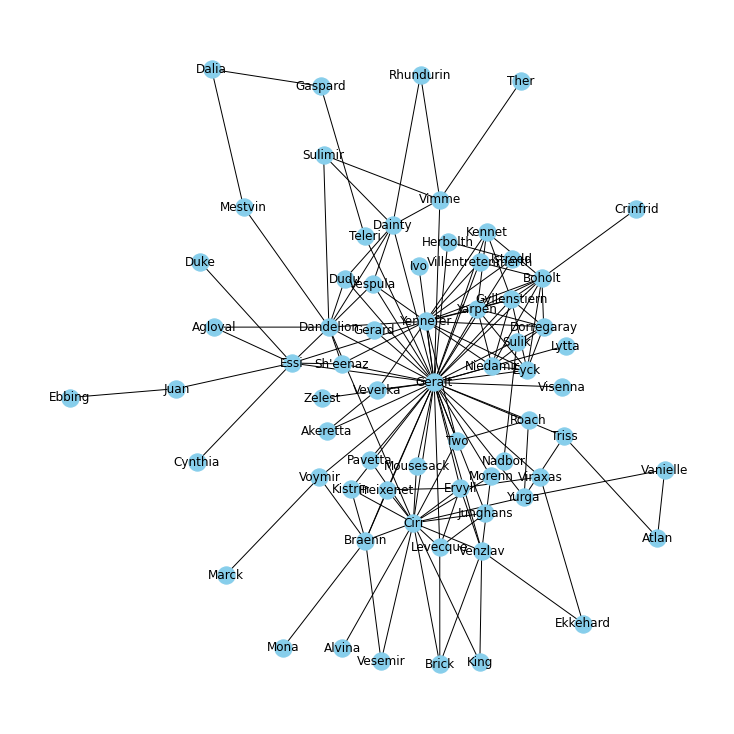

In [27]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

**Visualize using pyvis**

In [28]:
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("witcher.html")

**Themonst important characters in the series**

In [29]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Geralt': 0.6515151515151515,
 'Niedamir': 0.10606060606060606,
 'Eyck': 0.10606060606060606,
 'Dorregaray': 0.10606060606060606,
 'Yennefer': 0.24242424242424243,
 'Boholt': 0.15151515151515152,
 'Yarpen': 0.12121212121212122,
 'Gyllenstiern': 0.12121212121212122,
 'Kennet': 0.07575757575757576,
 'Crinfrid': 0.015151515151515152,
 'Villentretenmerth': 0.045454545454545456,
 'Istredd': 0.045454545454545456,
 'Herbolth': 0.030303030303030304,
 'Ivo': 0.015151515151515152,
 'Two': 0.06060606060606061,
 'Dandelion': 0.16666666666666669,
 'Vespula': 0.06060606060606061,
 'Dainty': 0.10606060606060606,
 'Vimme': 0.07575757575757576,
 'Sulimir': 0.045454545454545456,
 'Ther': 0.015151515151515152,
 'Rhundurin': 0.030303030303030304,
 'Dudu': 0.045454545454545456,
 "Sh'eenaz": 0.06060606060606061,
 'Gaspard': 0.030303030303030304,
 'Teleri': 0.030303030303030304,
 'Dalia': 0.030303030303030304,
 'Mestvin': 0.030303030303030304,
 'Essi': 0.12121212121212122,
 'Gerard': 0.015151515151515152,
 

<AxesSubplot:>

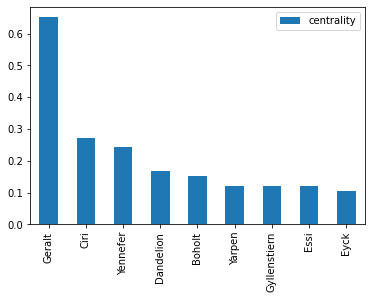

In [30]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot:>

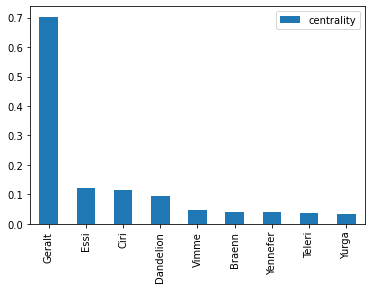

In [31]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot:>

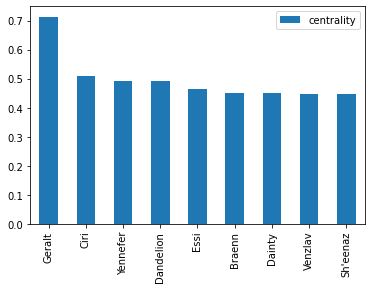

In [32]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [33]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

**Community detection of characters**

In [37]:
communities = community_louvain.best_partition(G)

In [38]:
nx.set_node_attributes(G, communities, 'group')

In [39]:
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("witcher_communities.html")

**Evolution of characters' importance**

In [40]:
# Initialize empty list for graphs from books
books_graph = []
all_books = [b for b in os.scandir('data') if '.txt' in b.name]
# Load spacy English languague model
nlp = spacy.load("en_core_web_sm")

# Sort dir entries by name
all_books.sort(key=lambda x: x.name)

In [41]:
# Loop through book list and create graphs
for book in all_books:
    book_text = ner(book)
    
    # Get list of entities per sentences
    sent_entity_df = get_ne_list_per_sentence(book_text)
    
    # Select only character entities
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

    # Filter out sentences that don't have any character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
    
    # Take only first name of characters
    sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

    # Create relationship df
    relationship_df = create_relationships(df = sent_entity_df_filtered, window_size = 5)                                                                                                               
    
    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())     
    
    books_graph.append(G) 

C:\Users\oluwanifemi.aweda\AppData\Local\Temp\ipykernel_14732\4223697425.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
C:\Users\oluwanifemi.aweda\AppData\Local\Temp\ipykernel_14732\4223697425.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
C:\Use

<AxesSubplot:>

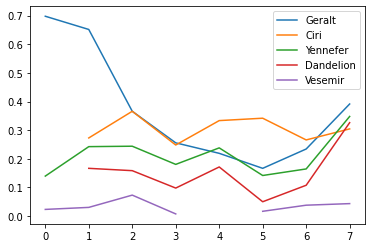

In [42]:
# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of 5 main characters
degree_evol_df[["Geralt", "Ciri", "Yennefer", "Dandelion", "Vesemir"]].plot()